# Lab 2: Transfer Learning & Transformers: Comparison of Transformer Architecture to Other Neural Networks in Evaluation of Movie Reviews and Ratings

Group Members:

- Parker Brown

- Suma Chackola

- Chris Peters

- Oliver Raney



**The execution of this lab was performed collaboratively across 4 computers. Therefore, while the individual cells are not all shown with the direct execution results, the code presented in those cells was utilized to produce the results in this notebook.**


<a id="top"></a>
## Contents
* <a href="#P1">1.0 Introduction & Dataset Overview</a>
* <a href="#P2">2.0 Transfer Learning Foundational Model </a>
* <a href="#P3">3.0 Splitting the Data </a>
* <a href="#P4">4.0 Training a Model from Scratch </a>
* <a href="#P5">5.0 Training a Model by Transfer Learning from Foundational Model </a>
* <a href="#P6">6.0 Fine-Tuning the Model </a>
* <a href="#P6">7.0 Results: Comparing All Investigated Models </a>
________________________________________________________________________________________________________


<a href="#top">Back to Top</a>
<a id="P1"></a>
## 1.0 Introduction & Dataset Overview
#### Give an overview of the dataset you have chosen to use. What is the classification task. Is this multi-task? Explain. What is the feature data? Who collected the data? Why? When? Is the data multi-modal? What evaluation criteria will you be using and why? 

In this lab, we are performing classification on Movie Review text to associate the text of the review with an overall "positivity" rating of Positive, Neutral, or Negative. By reviewing the text as a whole instead of sets of words or phrases, we are evaluating a sequential text to classify it into a distinct category.  

### Dataset Overview
The dataset we are using for this analysis comes from an IEEE Open Access repository at the following source: 
- Data Source: https://ieee-dataport.org/open-access/imdb-movie-reviews-dataset

The dataset compiles movie reviews from the Internet Movie Database (IMDb),  https://www.imdb.com/, and contains 1 million reviews from 1150 movies spread across 17 genres. In this dataset is other metadata such as the IMDb rating and movie rating. The data was compiled by Pal, Barigidad, and Mustafi and utilized and presented as a paper at the 2020 International Conference on Computing, Communication, and Security (ICCCS). In their analysis, they used the content of the movie reviews to classify the genre of the movie through word tokenization and a keyword list specific to the genre, and from their results they created a "Movie Recommender" based on a genre input from a user.

This is not a multi-modal dataset because it only contains textual data. We did not choose a multi-modal dataset, although there are other IMDb datasets that do contain multi-modal data, such as this one: https://arxiv.org/abs/1702.01992, which contains images of the poster of the movie, in addition to the movie genre, rating, and other text. 

### Classification Task
We utilized this dataset in Lab 1 for this course, where we performed sentiment analysis on the movie reviews and compared that sentiment to the movie positivity rating. For this lab, we differentiate that approach by using neural networks with a word embedding vectorizer to train a model. The training will analyze the sequential text in the review and use the associated rating to learn how the overall sequence relates to the positivity with respect to the vectorization of the sequence. Once that association is learned, the model evaluates new review sequences to classify those to an appropriate rating using the same vectorization analysis approach. 

In the dataset, the reviews are rated on a scale of 1-10. With our classifier, we will expect to get a similar scale, so that it is a multi-class classification task. We plan to segment the results into generalized score categories of:
- Score < 3.5 -> "Negative"
- 3.5 < Score < 6.5 -> "Neutral"
- 6.5 < Score -> "Positive"

### Evaluation Criteria



<a href="#top">Back to Top</a>
<a id="P2"></a>
## 2.0 Transfer Learning Foundational Model
#### Describe the foundational model that you will be using to transfer learn from. What tasks was this foundational model trained upon? Explain if the new task is within the same domain, across domains, etc. 

### Foundational Model: BERT

<a href="#top">Back to Top</a>
<a id="P3"></a>
## 3.0 Splitting the Data 
#### Split the data into training and testing. Be sure to explain how you performed this operation and why you think it is reasonable to split this particular dataset this way. For multi-task datasets, be sure to explain if it is appropriate to stratify within each task. If the dataset is already split for you, explain how the split was achieved and how it is stratified.

The dataset was compiled without regard to the distribution of the rating. In a plot below, we show that the data is heaviliy weighted towards positive reviews (with the majority ratings of 9 or 10). However, there is a substantial number of reviews for all cases. One question to ask is if it is important to maintain the distribution of the ratings, or if it is more important to provide a classifier that can perform equally well regardless of the rating. Because of the distribution, we have a few options for the data:
1) Do no data augmentation & perform a random 80/20 split for Training & Test Data. From a positive perspective, this maintains all the data for evaluation, and the randomness should remove some bias in the results. Further, this is a straightforward splitting task. However, from a negative perspective, we expect bias in the results to remain and be pointed towards the positive entries.

2) Only keep ~28000 entries for each rating (Rating of 2 was the lowest quantity with 28000 entries). From a positive perspective, this is very significant statistically and should provide satisfactory data. From a negative perspective, we may lose data quality from the diversity of the text provided for different rating values.

3) Perform stratified shuffling & splitting. From a positive perspective, this is an improvement of option 1) in that new, "unexpected" bias, is not introduced through a random sampling. From a negative perspective, it still hold the bias towards the positive entries. However, one could argue that this bias towards a positive rating should be considered a "feature" of the data and perhaps means we should re-evaluate our "upper limit" for a "Neutral" rating. 

### Preparing Data

In [6]:
#imports
import os
import pandas as pd
import warnings
import matplotlib.pyplot as plt 


warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [7]:
#https://www.geeksforgeeks.org/how-to-iterate-over-files-in-directory-using-python/
# and https://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe



directory = 'data/movie_dataset/2_reviews_per_movie_raw'

dfs = list()

#Concatenate data into one pandas dataframe
for filename in os.listdir(directory):	
	data = pd.read_csv(os.path.join(directory, filename), header='infer')	
	dfs.append(data)
df = pd.concat(dfs, ignore_index=True)


df.head()



,username,rating,helpful,total,date,title,review
0,Imme-van-Gorp,7,102,123,30 January 2019,Unfortunately the ending ruined an otherwise ...,This movie is full of suspense. It makes you g...
1,sonofocelot-1,5,385,500,10 May 2016,...oh dear Abrams. Again.\n,I'll leave this review fairly concise. <br/><b...
2,mhodaee,5,110,143,4 August 2017,"Fantastic, gripping, thoroughly enjoyable, un...",I give the 5/10 out of the credit I owe to the...
3,fil-nik09,5,73,100,5 October 2016,Hmmm...\n,"First of all, I must say that I was expecting ..."
4,DVR_Brale,7,42,56,27 July 2016,Slow building & plot alternating claustrophob...,I've always loved movies with strong atmospher...


In [8]:
# retain only rating and review
df = df.drop(columns=['username', 'helpful', 'total', 'date','title'], errors='ignore')

#print unique ratings
df.rating.unique()


array(['7', '5', '9', '8', '10', 'Null', '6', '1', '4', '3', '2'],
      dtype=object)

In [9]:
#drop Null ratings
df = df[~df['rating'].str.contains('Null')]

# Convert "rating" to int
df= df.astype({'rating':'int'})
df.rating.unique()



array([ 7,  5,  9,  8, 10,  6,  1,  4,  3,  2])

In [10]:

# Drop rows where "rating" is NaN or reviews are missing
df = df.dropna(subset=['rating'])
df = df.dropna(subset=['review'])

df.head()

,rating,review
0,7,This movie is full of suspense. It makes you g...
1,5,I'll leave this review fairly concise. <br/><b...
2,5,I give the 5/10 out of the credit I owe to the...
3,5,"First of all, I must say that I was expecting ..."
4,7,I've always loved movies with strong atmospher...


In [11]:
df['review'] = df['review'].str.lower() 
df.head()

,rating,review
0,7,this movie is full of suspense. it makes you g...
1,5,i'll leave this review fairly concise. <br/><b...
2,5,i give the 5/10 out of the credit i owe to the...
3,5,"first of all, i must say that i was expecting ..."
4,7,i've always loved movies with strong atmospher...


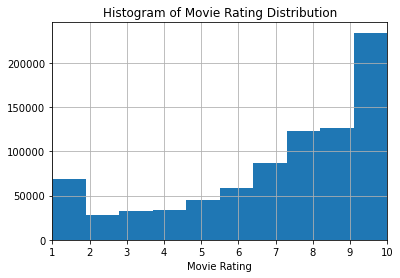

In [12]:
hist = df['rating'].hist(bins=10)
plt.title('Histogram of Movie Rating Distribution') 
plt.xlabel('Movie Rating') 
plt.xlim(1, 10)
plt.show()

In [13]:
num1 = (df['rating']==1).sum()
num2 = (df['rating']==2).sum()
num3 = (df['rating']==3).sum()
num4 = (df['rating']==4).sum()
num5 = (df['rating']==5).sum()
num6 = (df['rating']==6).sum()
num7 = (df['rating']==7).sum()
num8 = (df['rating']==8).sum()
num9 = (df['rating']==9).sum()
num10 = (df['rating']==10).sum()

print('Quantity of Ratings'
      '\n1:   ', num1, 
      '\n2:   ', num2, 
      '\n3:   ', num3, 
      '\n4:   ', num4, 
      '\n5:   ', num5, 
      '\n6:   ', num6, 
      '\n7:   ', num7, 
      '\n8:  ', num8, 
      '\n9:  ', num9, 
      '\n10: ', num10,
     '\n\nReconsidering a grouping of these ratings, we can see:',
      '\nNegative, Ratings 1-5:  ', num1+num2+num3+num4+num5,
      '\nNeutral,  Ratings 6-8:  ', num6+num7+num8, 
      '\nPositive, Ratings 9-10: ', num9+num10)


Quantity of Ratings
1:    68468 
2:    28002 
3:    32451 
4:    33254 
5:    44707 
6:    58567 
7:    87361 
8:   122542 
9:   126068 
10:  234182 

Reconsidering a grouping of these ratings, we can see: 
Negative, Ratings 1-5:   206882 
Neutral,  Ratings 6-8:   268470 
Positive, Ratings 9-10:  360250


<a href="#top">Back to Top</a>
<a id="P4"></a>
## 4.0 Training a Model from Scratch 
#### Train a model from scratch to perform the classification task (this does NOT need to be a transformer). That is, do not use transfer learning for the classification task. Verify the model converges (even if the model is overfit). This does NOT need to mirror the foundational model. This model may be far less computational to train.

### Model

In [14]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from keras.preprocessing.text import Tokenizer

# Model hyperparameters
max_length = 100
embedding_dim = 100
num_filters = 128
kernel_size = 5
hidden_dims = 128

# Tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['review'])
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 to account for the reserved 0 index

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Conv1D(num_filters, kernel_size, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dense(10, activation='softmax'))  # 10 rating classes

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          40694400  
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 128)          64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 40,776,330
Trainable params: 40,776,330
Non-trainable params: 0
_________________________________________________________________


### train_test_split

In [15]:
from keras.preprocessing.sequence import pad_sequences

sequences = tokenizer.texts_to_sequences(df['review'])

# Pad sequences to ensure uniform length
X = pad_sequences(sequences, maxlen=max_length)
y = df['rating'] - 1  # Adjust ratings to start from 0


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Train Model

In [17]:
import time

start_time = time.time()
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)  # Use 20% of the training data as validation data

elapsed_time = time.time() - start_time

print(f"Training took {elapsed_time:.2f} seconds.")


Epoch 1/10
16712/16712 [==============================] - 4560s 273ms/step - loss: 1.5047 - accuracy: 0.4415 - val_loss: 1.4376 - val_accuracy: 0.4617
Epoch 2/10
16712/16712 [==============================] - 4722s 283ms/step - loss: 1.3660 - accuracy: 0.4831 - val_loss: 1.4400 - val_accuracy: 0.4665
Epoch 3/10
16712/16712 [==============================] - 5108s 306ms/step - loss: 1.2446 - accuracy: 0.5248 - val_loss: 1.4912 - val_accuracy: 0.4541
Epoch 4/10
16712/16712 [==============================] - 5139s 307ms/step - loss: 1.0953 - accuracy: 0.5818 - val_loss: 1.6010 - val_accuracy: 0.4401
Epoch 5/10
16712/16712 [==============================] - 5440s 325ms/step - loss: 0.9394 - accuracy: 0.6432 - val_loss: 1.7834 - val_accuracy: 0.4205
Epoch 6/10
16712/16712 [==============================] - 5643s 338ms/step - loss: 0.7978 - accuracy: 0.6989 - val_loss: 2.1044 - val_accuracy: 0.4153
Epoch 7/10
16712/16712 [==============================] - 5074s 304ms/step - loss: 0.6789 - ac

### Plot Convergence

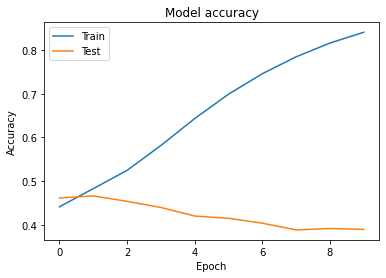

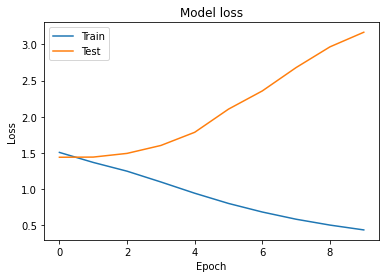

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


<a href="#top">Back to Top</a>
<a id="P5"></a>
## 5.0 Training a Model by Transfer Learning from Foundational Model 
#### Train a model by transfer learning from your foundational model. Verify that the new model converges. You only need to train a model using the bottleneck features for this step. 

<a href="#top">Back to Top</a>
<a id="P6"></a>
## 6.0 Fine-Tuning the Model 
#### Perform fine tuning upon the model by training some layers within the foundational model. Verify that the model converges. 
xx



<a href="#top">Back to Top</a>
<a id="P7"></a>
## 7.0 Results: Comparing All Investigated Models 
#### Report the results of all models using the evaluation procedure that you argued for at the beginning of the lab. Compare the convergence of the models and the running time. Results should be reported with proper statistical comparisons and proper visualizations.
xx